In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
import lightgbm as lgb
import xgboost as xgb
from sklearn import svm
from sklearn.neural_network import MLPRegressor
import sklearn.metrics as mtr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
import time
import seaborn as sns

生データ読み込み

In [2]:
raw_data=pd.read_csv('../data/ParameterListAll_20180702.csv',index_col=0)
columns=raw_data.columns

脳動脈瘤の位置をカテゴリ化

In [3]:
location_li=['IC_Pcom','IC_choro','MC_bifur','AC_Acom','A1_A2','AC_distal','BA_top','PCA','PICA']
raw_data['location']=np.zeros(len(raw_data))
for location in location_li:
    loc_id=raw_data[raw_data[location]==1].index
    raw_data['location'][loc_id]=location

日付を離散化

In [4]:
raw_data['LastConsulation']=pd.to_datetime(raw_data['LastConsulation'])

raw_data['month']=raw_data['LastConsulation'].dt.month.astype('int')
idx_3=raw_data[raw_data['month']<=3].index
idx_6=raw_data[(raw_data['month']>3)&(raw_data['month']<=6)].index
idx_9=raw_data[(raw_data['month']>6)&(raw_data['month']<=9)].index
idx_12=raw_data[raw_data['month']>9].index
raw_data['month'][idx_3]='1-3'
raw_data['month'][idx_6]='4-6'
raw_data['month'][idx_9]='7-9'
raw_data['month'][idx_12]='10-12'

raw_data['day']=raw_data['LastConsulation'].dt.day.astype('int')
idx_10=raw_data[raw_data['day']<=10].index
idx_20=raw_data[(raw_data['day']>10)&(raw_data['day']<=20)].index
idx_30=raw_data[raw_data['day']>20].index
raw_data['day'][idx_10]='1-10'
raw_data['day'][idx_20]='11-20'
raw_data['day'][idx_30]='21-31'

カテゴリ化

In [5]:
category_col=['location','SideorBifur','Sex', 'RightLeft', 'MultiSingle', 'HT', 'HL', 'DM', 'Alchol',
              'PolycysticKindney', 'CerebralHemorrhage', 'CerebralInfant', 'SAH',
              'none', 'Smoke', 'family_SAH', 'family_An', 'family_PolycysticKindney','bleb','month','day']
raw_data[category_col]=raw_data[category_col].astype('category')

いらない特徴の削除

In [6]:
drop_li=['FirstDiagnosis', 'InitialConsultation', 'LastConsulation',
         'DateofRupture', 'Birthday', 'AgeatIniCon','Days','IC_Pcom',
         'IC_choro', 'MC_bifur', 'AC_Acom', 'A1_A2', 'AC_distal',
         'BA_top', 'PCA', 'PICA']
raw_data=raw_data.drop(drop_li,axis=1)

追加特徴

In [7]:
raw_data['PLcver2R']=(raw_data['TMAXPLcver2']/raw_data['TMINPLcver2']).replace([np.inf, -np.inf], np.nan).fillna(0)
raw_data['PLcOldver2R']=(raw_data['TMAXPLcOldver2']/raw_data['TMINPLcOldver2']).replace([np.inf, -np.inf], np.nan).fillna(0)
raw_data['ELR']=(raw_data['TMAXEL']/raw_data['TMINEL']).replace([np.inf, -np.inf], np.nan).fillna(0)
raw_data['ELVR']=(raw_data['TMAXELV']/raw_data['TMINELV']).replace([np.inf, -np.inf], np.nan).fillna(0)

raw_data['SCIR']=(raw_data['TMAXSCI']/raw_data['TMINSCI']).replace([np.inf, -np.inf], np.nan).fillna(0)
raw_data['LSIR']=(raw_data['TMAXLSI']/raw_data['TMINLSI']).replace([np.inf, -np.inf], np.nan).fillna(0)
raw_data['LSAR']=(raw_data['TMAXLSA']/raw_data['TMINLSA']).replace([np.inf, -np.inf], np.nan).fillna(0)
raw_data['ICIR']=(raw_data['TMAXICI']/raw_data['TMINICI']).replace([np.inf, -np.inf], np.nan).fillna(0)

In [8]:
features=['velocities','shear_force','pressure','wss']
statistics=['max','var']
feature_statistics=[f+'_'+m for m in statistics for f in features]
width_length=1
for i in range(len(feature_statistics)):
    data=pd.read_csv('../../VTK/output/'+feature_statistics[i]+'.csv',index_col=0)
    data['ID']=([x.split('/')[0] for x in list(data.index)])
    data=data.set_index('ID')
    data=data.drop('Unnamed: 19',axis=1)
    columns=[round(0.05*x,3) for x in range(18)]
    data.columns=columns
    
    for width in range(width_length):
        width+=1
        
        changed_data=data.pct_change(width,axis=1)
        changed_data=changed_data.drop([round(0.0+0.05*x,3) for x in range(width)],axis=1)
        columns=[feature_statistics[i]+'_'+str(round(0.05*x,3))+'_'+str(round(0.05*(x+width),3)) for x in range(18-width)]
        changed_data.columns=columns

        raw_data=raw_data.join(changed_data.replace([np.inf, -np.inf], np.nan).fillna(0))
""" 
for i in range(len(feature_statistics)):
    data=pd.read_csv('../../VTK/output/'+feature_statistics[i]+'.csv',index_col=0)
    data['ID']=([x.split('/')[0] for x in list(data.index)])
    data=data.set_index('ID')
    data=data.drop('Unnamed: 19',axis=1)
    columns=[round(0.05*x,3) for x in range(18)]
    data.columns=columns
    
    for width in range(width_length):
        width+=1
        
        changed_data=data.diff(width,axis=1)
        changed_data=changed_data.drop([round(0.0+0.05*x,3) for x in range(width)],axis=1)
        columns=[feature_statistics[i]+'_'+str(round(0.05*x,3))+'_'+str(round(0.05*(x+width),3))+'_diff' for x in range(18-width)]
        changed_data.columns=columns

        raw_data=raw_data.join(changed_data.replace([np.inf, -np.inf], np.nan).fillna(0))
""" 

" \nfor i in range(len(feature_statistics)):\n    data=pd.read_csv('../../VTK/output/'+feature_statistics[i]+'.csv',index_col=0)\n    data['ID']=([x.split('/')[0] for x in list(data.index)])\n    data=data.set_index('ID')\n    data=data.drop('Unnamed: 19',axis=1)\n    columns=[round(0.05*x,3) for x in range(18)]\n    data.columns=columns\n    \n    for width in range(width_length):\n        width+=1\n        \n        changed_data=data.diff(width,axis=1)\n        changed_data=changed_data.drop([round(0.0+0.05*x,3) for x in range(width)],axis=1)\n        columns=[feature_statistics[i]+'_'+str(round(0.05*x,3))+'_'+str(round(0.05*(x+width),3))+'_diff' for x in range(18-width)]\n        changed_data.columns=columns\n\n        raw_data=raw_data.join(changed_data.replace([np.inf, -np.inf], np.nan).fillna(0))\n"

In [9]:
""" 
for i in range(len(feature_statistics)):
    add_data=pd.read_csv('../../VTK/output/'+feature_statistics[i]+'.csv',index_col=0)
    add_data['ID']=([x.split('/')[0] for x in list(add_data.index)])
    add_data=add_data.set_index('ID')
    add_data=add_data.drop('Unnamed: 19',axis=1)
    columns=[feature_statistics[i]+'_'+str(round(0.05*x,3)) for x in range(18)]
    add_data.columns=columns
    add_data=add_data.replace([np.inf, -np.inf], np.nan).fillna(0)
    raw_data=raw_data.join(add_data)
""" 

" \nfor i in range(len(feature_statistics)):\n    add_data=pd.read_csv('../../VTK/output/'+feature_statistics[i]+'.csv',index_col=0)\n    add_data['ID']=([x.split('/')[0] for x in list(add_data.index)])\n    add_data=add_data.set_index('ID')\n    add_data=add_data.drop('Unnamed: 19',axis=1)\n    columns=[feature_statistics[i]+'_'+str(round(0.05*x,3)) for x in range(18)]\n    add_data.columns=columns\n    add_data=add_data.replace([np.inf, -np.inf], np.nan).fillna(0)\n    raw_data=raw_data.join(add_data)\n"

In [10]:
add_data=pd.read_csv('../data/curvature.csv',index_col=0)
drop_li_cu=['IC_Pcom', 'IC_choro', 'MC_bifur', 'AC_Acom', 'A1_A2', 'AC_distal','BA_top', 'PCA', 'PICA','rupture']
add_data=add_data.drop(drop_li_cu,axis=1)
add_data['mean_curvature_R']=add_data['max_mean_curvature']/add_data['min_mean_curvature']
add_data['gaussian_curvature_R']=add_data['max_gaussian_curvature']/add_data['min_gaussian_curvature']
add_data['rms_curvature_R']=add_data['max_rms_curvature']/add_data['min_rms_curvature']
add_data['abs_curvature_R']=add_data['max_abs_curvature']/add_data['min_abs_curvature']
add_data=add_data.replace([np.inf, -np.inf], np.nan).fillna(0)
raw_data=raw_data.join(add_data)

関数系読み込み

In [11]:
def make_normal_data(raw_data):
    x=raw_data
    y=pd.DataFrame(x['Rupture'],columns=['Rupture'])
    x=x.drop('Rupture',axis=1)
    return x,y

In [12]:
def make_data(new_data,columns):
    data_num=len(new_data)
    x=pd.concat([new_data[i] for i in range(data_num)],axis=1)
    x.columns=columns
    return x

In [13]:
def get_dummy(x,dummy_col):
    x_dummy=pd.get_dummies(x[dummy_col])
    x=pd.concat([x,x_dummy],axis=1)
    x=x.drop(dummy_col,axis=1)
    return x

In [14]:
def machine_learning(model_name,cv_name,x,y,params):
    start=time.time()
    standard_li=['svm','nn']
    return_importances=['lgb','xgb']
    return_prob=['svm']
    #thre_ratio=0.80
    thre_ratio=0.90
    rec_bias=0.85
    #params['random_state']=2**3-1
    params['random_state']=2**2-1
    columns=x.columns
    importances=np.zeros(x.shape[1])
    importances_dic={}
    
    
    for column in columns:
        importances_dic[column]=0
    pre=np.zeros(len(x))
    pre_test=np.zeros(len(x))
    prob=np.zeros(len(x))
    #CVの選択
    if cv_name=='loo':
        cv=LeaveOneOut()
        n_split=len(x)
    else:
        cv=StratifiedKFold(n_splits=cv_name,shuffle=True,random_state=params['random_state']) 
        n_split=cv_name
        
    count=0
    split_point=[int((n_split/5)*(i+1)) for i in range(5)]
    for train_idx,val_idx in cv.split(x,y):
        x_train=x.iloc[train_idx]
        y_train=y.iloc[train_idx]
        x_val=x.iloc[val_idx]
        y_val=y.iloc[val_idx]
        
        #モデルの選択
        if model_name=='lgb':
            model=lgb.LGBMModel(**params)
            model.fit(x_train,y_train)
            pre[val_idx]=model.predict(x_val)
            
            predict_train=model.predict(x_train)
            best_score=0
            best_thre=0
            rec_li=[]
            spe_li=[]
            for threshold in predict_train:
                pre_train=np.where(predict_train>=threshold,1,0)
                rec=mtr.recall_score(y_train,pre_train)
                spe=mtr.recall_score(y_train,pre_train,pos_label=0)
                rec_li.append(rec)
                spe_li.append(spe)
                
                score=(2*rec*rec_bias*spe)/(rec*rec_bias+spe)
                if score>best_score:
                    best_thre=threshold*thre_ratio
                    best_score=score
                    best_rec=rec
                    best_spe=spe
            pre_test[val_idx]=np.where(model.predict(x_val)>best_thre,1,0)
            importances+=model.feature_importances_

            x_f='TAPLcver2'
            t=pd.DataFrame(predict_train,index=train_idx,columns=['predict'])
            t['ID']=x_train.index
            t=t.set_index('ID')
            for idx in y_train[y_train['Rupture']==0].index:
                plt.scatter(x_train.loc[idx][x_f],t.loc[idx]['predict'],color='b')
            for idx in y_train[y_train['Rupture']==1].index:
                plt.scatter(x_train.loc[idx][x_f],t.loc[idx]['predict'],color='r') 
            plt.xlabel(x_f)
            plt.ylabel('score')
            plt.savefig('../output/lgb.png')
            plt.show()
            
            rec_spe=pd.DataFrame(np.array([rec_li,spe_li]).T,columns=['recall','specificity']).sort_values(['recall', 'specificity'])
            plt.figure(figsize=(5, 5))
            plt.xlim(0,1.1)
            plt.ylim(0,1.1)
            plt.scatter(rec_spe["recall"], rec_spe["specificity"],marker='o',c='b')
            plt.scatter(best_rec,best_spe,marker='o',c='r')
            plt.savefig('../output/lgb_sample.png')
            plt.show()
            print('best_thre:'+str(best_thre))
            
            
        elif model_name=='xgb':
            train = xgb.DMatrix(x_train.as_matrix(),label=y_train.values, feature_names = columns)
            test=xgb.DMatrix(x_val.as_matrix(), feature_names = columns)
            model = xgb.train(params,train)
            pre[val_idx]=model.predict(test)   
            for key_value in model.get_fscore().items():
                k=key_value[0]
                v=key_value[1]
                importances_dic[k]+=v
            
            predict_train=model.predict(train)
            best_score=0
            best_thre=0
            rec_li=[]
            spe_li=[]
            for threshold in predict_train:
                pre_train=np.where(predict_train>=threshold,1,0)
                rec=mtr.recall_score(y_train,pre_train)
                spe=mtr.recall_score(y_train,pre_train,pos_label=0)
                rec_li.append(rec)
                spe_li.append(spe)

      
                #score=(1*rec_bias-rec)**2+(1-spe)**2
                score=(2*rec*rec_bias*spe)/(rec*rec_bias+spe)
                if score>best_score:
                    best_thre=threshold*thre_ratio
                    best_score=score
                    best_rec=rec
                    best_spe=spe


            x_f='TAPLcver2'
            t=pd.DataFrame(predict_train,index=train_idx,columns=['predict'])
            t['ID']=x_train.index
            t=t.set_index('ID')
            for idx in y_train[y_train['Rupture']==0].index:
                plt.scatter(x_train.loc[idx][x_f],t.loc[idx]['predict'],color='b')
            for idx in y_train[y_train['Rupture']==1].index:
                plt.scatter(x_train.loc[idx][x_f],t.loc[idx]['predict'],color='r') 
            plt.xlabel(x_f)
            plt.ylabel('score')
            plt.savefig('../output/xgb.png')
            plt.show()
  
            
            rec_spe=pd.DataFrame(np.array([rec_li,spe_li]).T,columns=['recall','specificity']).sort_values(['recall', 'specificity'])
            plt.figure(figsize=(5, 5))
            plt.xlim(0,1.1)
            plt.ylim(0,1.1)
            plt.scatter(rec_spe["recall"], rec_spe["specificity"],marker='o',c='b')
            plt.scatter(best_rec,best_spe,marker='o',c='r')
            plt.savefig('../output/xgb_sample.png')
            plt.show()
            print('best_thre:'+str(best_thre))
            pre_test[val_idx]=np.where(model.predict(test)>=best_thre,1,0)
            
        else:
            if model_name=='svm':
                model=svm.SVC(**params)
            elif model_name=='nn':
                model=MLPRegressor(hidden_layer_sizes=(100,100,))
            #正規化の可否
            columns=x_train.columns
            svmidx_train=x_train.index
            if model_name in standard_li:
                sc=StandardScaler()
                sc.fit(x_train)
                x_train=pd.DataFrame(sc.transform(x_train),index=x_train.index,columns=columns)
                x_val=pd.DataFrame(sc.transform(x_val),index=x_val.index,columns=columns)

            model.fit(x_train,y_train)
            pre[val_idx]=model.predict(x_val)
            
            if model_name=='svm':
                prob[val_idx]=model.predict_proba(x_val)[:,1]
            
            predict_train=model.predict_proba(x_train)[:,1]
            best_score=0
            best_thre=0
            rec_li=[]
            spe_li=[]
            for threshold in predict_train:
                pre_train=np.where(predict_train>=threshold,1,0)
                rec=mtr.recall_score(y_train,pre_train)
                spe=mtr.recall_score(y_train,pre_train,pos_label=0)
                rec_li.append(rec)
                spe_li.append(spe)
                score=(2*rec*rec_bias*spe)/(rec*rec_bias+spe)
                if score>best_score:
                    best_thre=threshold*thre_ratio
                    best_score=score
                    best_rec=rec
                    best_spe=spe
            pre_test[val_idx]=np.where(model.predict_proba(x_val)[:,1]>=best_thre,1,0)
            
            x_f='TAPLcver2'
            t=pd.DataFrame(predict_train,index=train_idx,columns=['predict'])
            t['ID']=x_train.index
            t=t.set_index('ID')
            for idx in y_train[y_train['Rupture']==0].index:
                plt.scatter(x_train.loc[idx][x_f],t.loc[idx]['predict'],color='b')
            for idx in y_train[y_train['Rupture']==1].index:
                plt.scatter(x_train.loc[idx][x_f],t.loc[idx]['predict'],color='r') 
            plt.xlabel(x_f)
            plt.ylabel('score')
            plt.savefig('../output/svm.png')
            plt.show()
            
            rec_spe=pd.DataFrame(np.array([rec_li,spe_li]).T,columns=['recall','specificity']).sort_values(['recall', 'specificity'])
            plt.figure(figsize=(5, 5))
            plt.xlim(0,1.1)
            plt.ylim(0,1.1)
            plt.scatter(rec_spe["recall"], rec_spe["specificity"],marker='o',c='b')
            plt.scatter(best_rec,best_spe,marker='o',c='r')
            plt.savefig('../output/svm_sample.png')
            plt.show()
            print('best_thre:'+str(best_thre))
        count+=1
        if count in split_point:
            print(str(int(count/n_split*100+0.5))+'%完了')
    pre=pd.DataFrame(pre,columns=['predict'],index=x.index)
    end=time.time()
    print('実行時間:'+str(int(end-start))+'s')
        
    if model_name in return_importances:
        if model_name=='xgb':
            importances=np.array(list(importances_dic.values()))
        importances=importances/sum(abs(importances))
        return pre,importances,pre_test
    elif model_name in return_prob:
        prob=pd.DataFrame(prob,index=x.index)
        return pre,prob,pre_test
    
    else:
        return pre,pre_test

In [15]:
def make_threshold(y,pre,n_iter):
    mtr_li=[]
    f1_max=0
    for i in range(n_iter):
        predict=np.where(pre>1/n_iter*i,1,0)
        f1=mtr.f1_score(y['Rupture'],predict)
        recall=mtr.recall_score(y['Rupture'],predict)
        mtr_li.append((f1,recall,1/n_iter*i))
        if f1>f1_max:
            f1_max=f1
            idx=i
    return mtr_li[idx]

In [16]:
def importances_plot(importances, columns, max_row=50):
    df = pd.DataFrame({'importances': importances, 'features': columns})
    df = df.sort_values('importances', ascending=False).reset_index(drop=True).iloc[:max_row, :]
    sns.barplot(x='importances', y='features', data=df)
    plt.show()

In [17]:
def result(x,y,pre,threshold,fig_name):
    x_f='MaxHeight'
    for idx in y[y['Rupture']==0].index:
        plt.scatter(x.loc[idx][x_f],pre.loc[idx],color='b')
    for idx in y[y['Rupture']==1].index:
        plt.scatter(x.loc[idx][x_f],pre.loc[idx],color='r') 
    plt.xlabel('Age')
    plt.ylabel('score')
    plt.savefig('../output/'+fig_name+'.png')
    plt.show()
    predict=np.where(pre>threshold,1,0)
    print('f1',mtr.f1_score(y,predict))
    print('rec',mtr.recall_score(y,predict))
    print('spe',mtr.recall_score(y,predict,pos_label=0))
    
    return predict

In [18]:
lgb_params = {
    'max_depth':3,
    'num_iterations':100,
    'learning_rate': 0.05,
    'objective': 'binary',
    'silent':False,
    
}

svm_params={
    'probability':True,
    'C':0.01,
}

xgb_params = {
    'objective':'binary:logistic',
    'eta':0.05,
    'max_depth':3,
    'min_child_weigh':1,
}


In [19]:
c_info=['AgeatRuporLasCon','Sex','MultiSingle','HT','HL','DM','Alchol','PolycysticKindney','CerebralHemorrhage','CerebralInfant','SAH','none','Smoke','family_SAH','family_An','family_PolycysticKindney','location','month','day']
len(c_info)
h_info=['SideorBifur','MaxHeight','MaxNeck','NeckArea','Volume','AR2','RightLeft','bleb','min_mean_curvature','max_mean_curvature','min_gaussian_curvature','max_gaussian_curvature','min_rms_curvature','max_rms_curvature','min_abs_curvature','max_abs_curvature','mean_curvature_R','gaussian_curvature_R','rms_curvature_R','abs_curvature_R']
len(h_info)

20

In [20]:
a=['TMINSAWSS','TMAXSAWSS','TMINSMAXWSS','TMAXSMAXWSS','TMINSMINWSS','TMAXSMINWSS','TMINICI','TMAXICI','TMINLSA','TMAXLSA','TMINLSI','TMAXLSI','TMINPLcver2','TMAXPLcver2','TMINPLcOldver2','TMAXPLcOldver2','TMINEL','TMAXEL','TMINELV','TMAXELV','TMINSCI','TMAXSCI','TAICI','TALSA','TALSI','TAMNWSS','TASANWSS','SATAWSS','SMAXTAWSS','SMINTAWSS','TAEL','TAELV','TAPLcver2','TAPLcOldver2','TASCI','SAOSI','SMAXOSI']
len(a)
b=['PLcver2R','PLcOldver2R','ELR','ELVR','SCIR','LSIR','LSAR','ICIR']
len(b)

8

In [21]:
raw_data=raw_data.drop(c_info,axis=1)
raw_data=raw_data.drop(h_info,axis=1)
x,y=make_normal_data(raw_data)

#x_dummy=get_dummy(x,['location','month','day'])
x_dummy=x
cv_name=10
threshold_lgb=0.10
threshold_svm=0.10
threshold_xgb=0.25

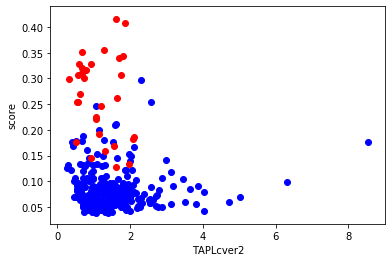

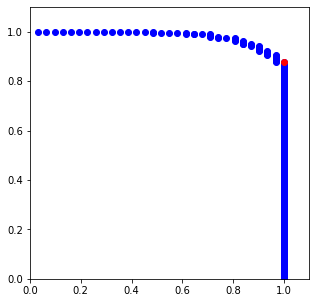

best_thre:0.11531786065971263


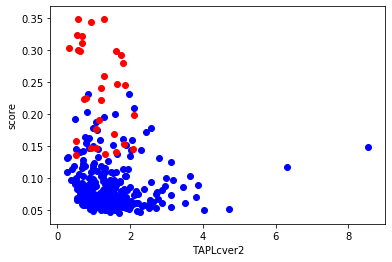

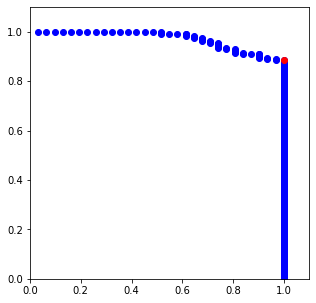

best_thre:0.12255204576845809
20%完了


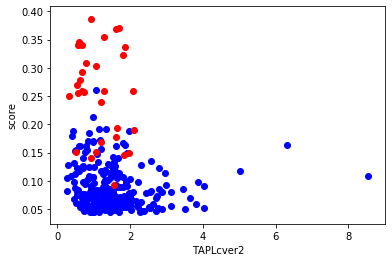

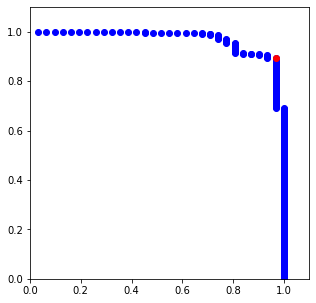

best_thre:0.1259524449848266


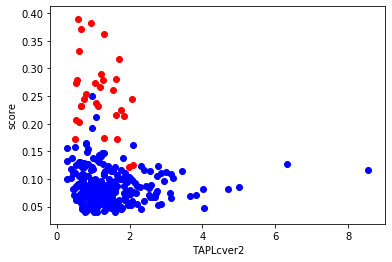

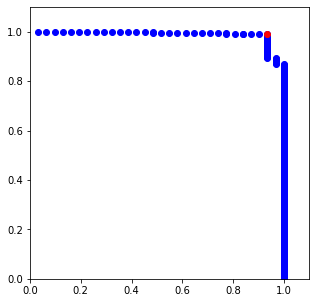

best_thre:0.15443303431243632
40%完了


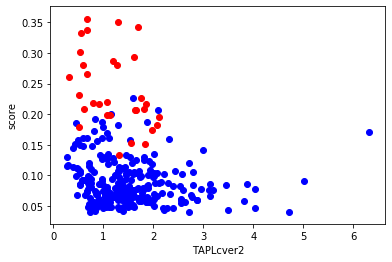

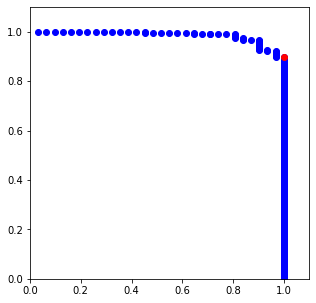

best_thre:0.12038291795206749


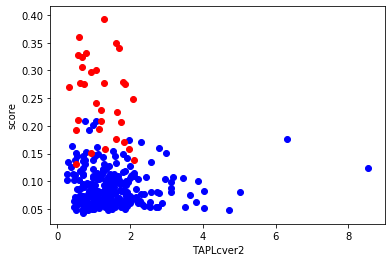

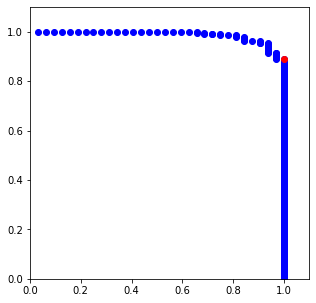

best_thre:0.11850188589806358
60%完了


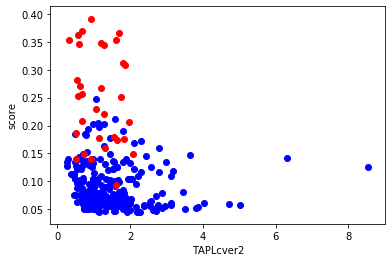

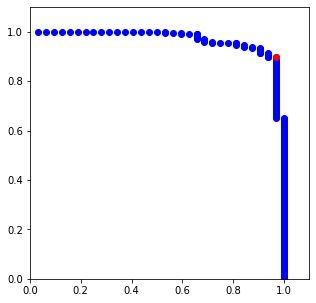

best_thre:0.12550715957715414


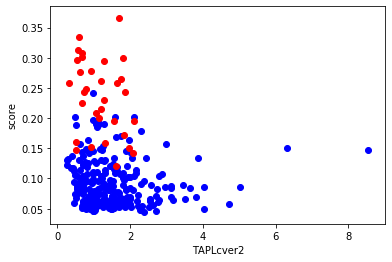

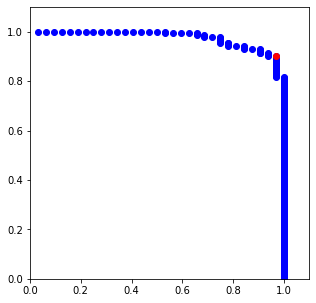

best_thre:0.12842947005652533
80%完了


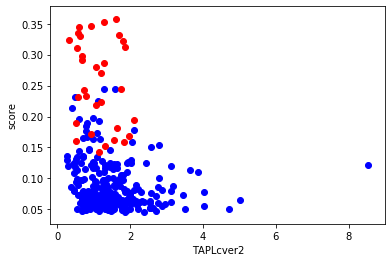

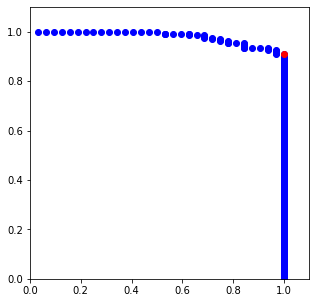

best_thre:0.12897461494552012


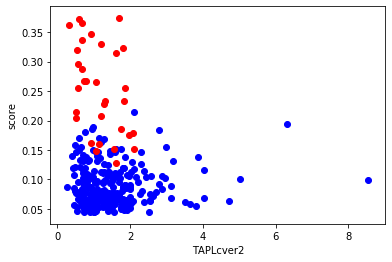

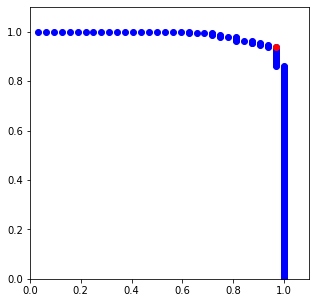

best_thre:0.13382084301540173
100%完了
実行時間:18s
0.1607142857142857
0.2571428571428571
0.7755775577557755


In [22]:
pre,imp,pre_test=machine_learning('lgb',cv_name,x,y,lgb_params)
print(mtr.f1_score(y,pre_test))
print(mtr.recall_score(y,pre_test))
print(mtr.recall_score(y,pre_test,pos_label=0))

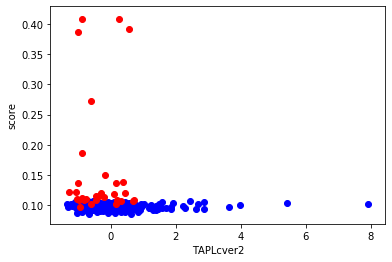

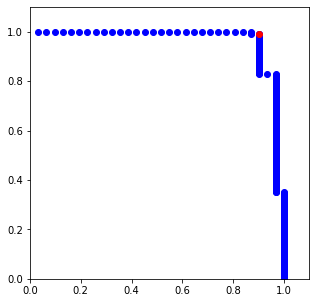

best_thre:0.09614940893512161


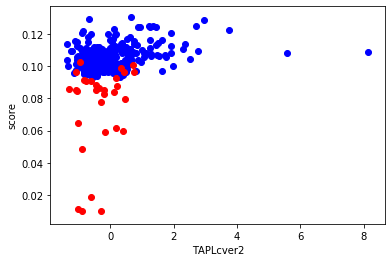

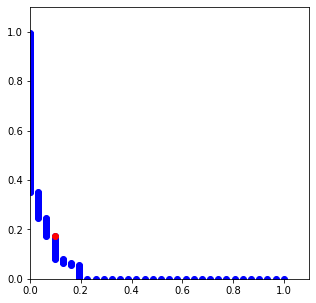

best_thre:0.08892235688581826
20%完了


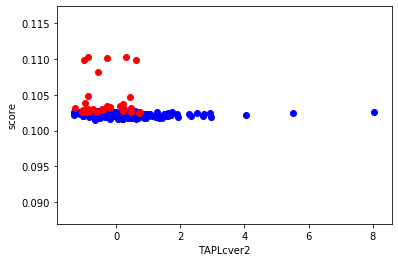

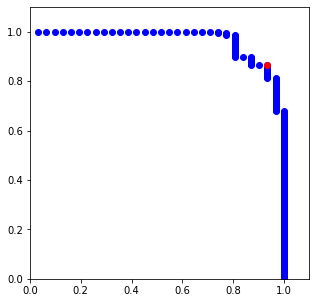

best_thre:0.09230545040650852


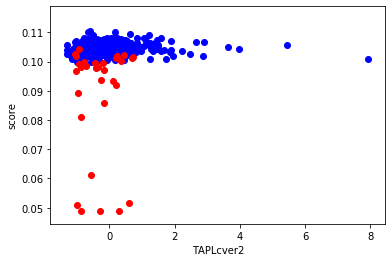

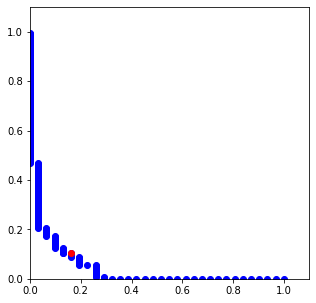

best_thre:0.0916411314367859
40%完了


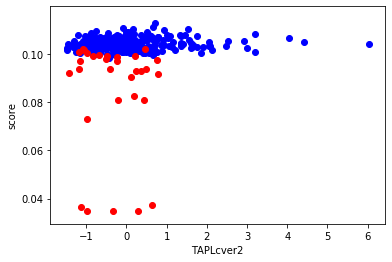

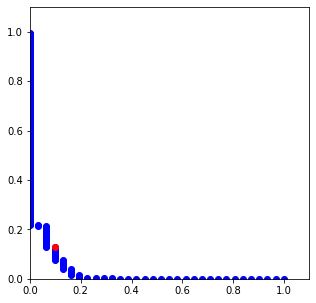

best_thre:0.09148163416604843


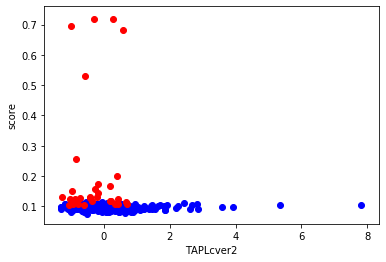

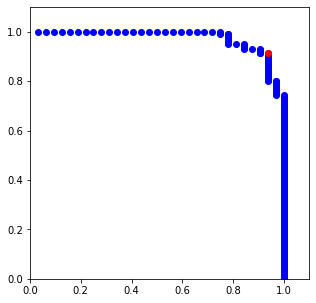

best_thre:0.0967760342196981
60%完了


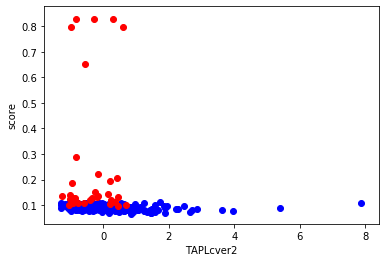

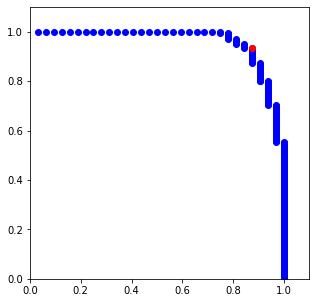

best_thre:0.09623478907414011


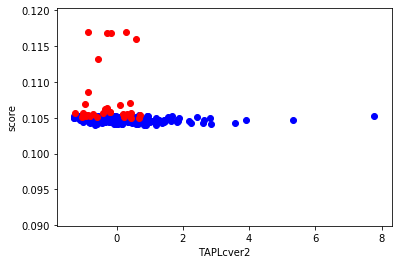

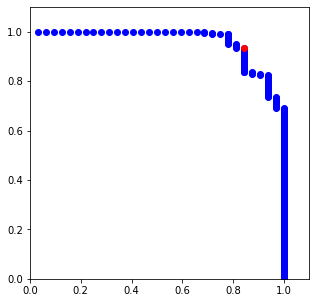

best_thre:0.09466575083566327
80%完了


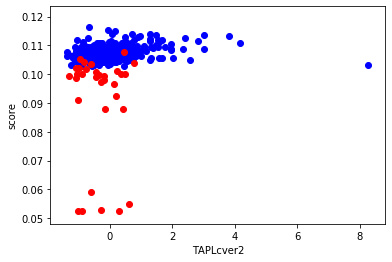

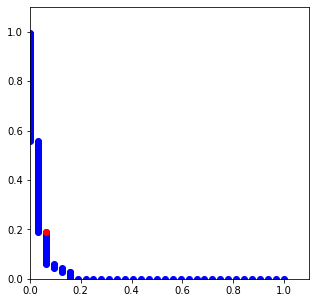

best_thre:0.09482165866913511


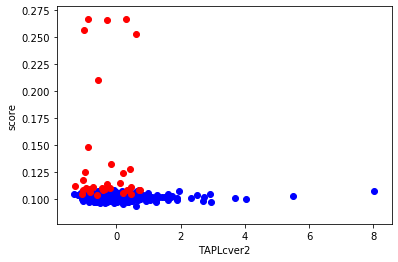

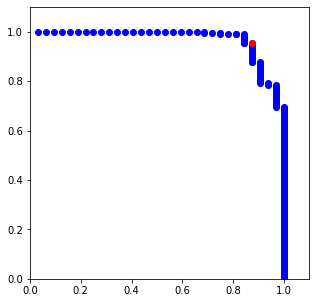

best_thre:0.0963896138949731
100%完了
実行時間:15s
0.16352201257861637
0.7428571428571429
0.15181518151815182


In [23]:
pre_svm,prob_svm,pre_test_svm=machine_learning('svm',cv_name,x_dummy,y,svm_params)
print(mtr.f1_score(y,pre_test_svm))
print(mtr.recall_score(y,pre_test_svm))
print(mtr.recall_score(y,pre_test_svm,pos_label=0))

In [24]:
303*.6831683168316832

207.00000000000003

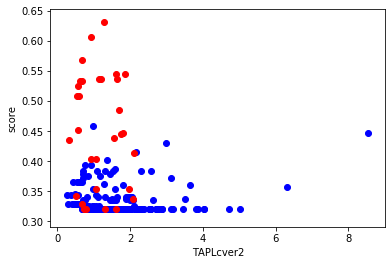

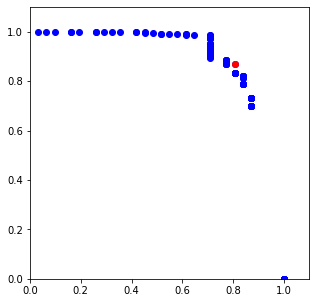

best_thre:0.3087593257427216


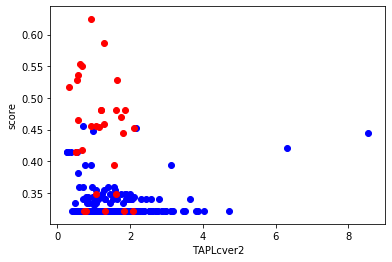

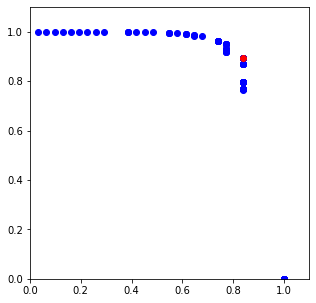

best_thre:0.31395117044448856
20%完了


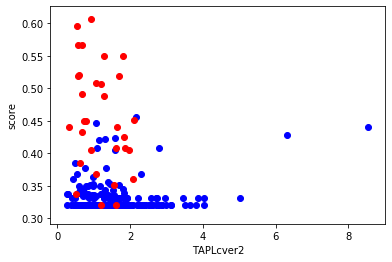

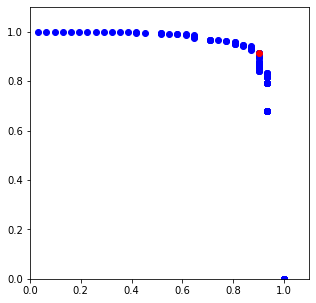

best_thre:0.3168060600757599


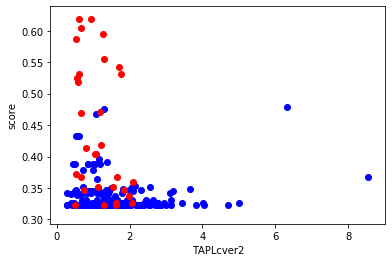

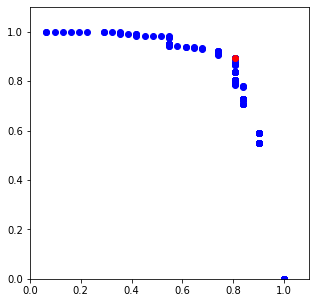

best_thre:0.31227564811706543
40%完了


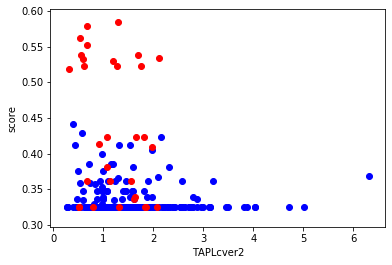

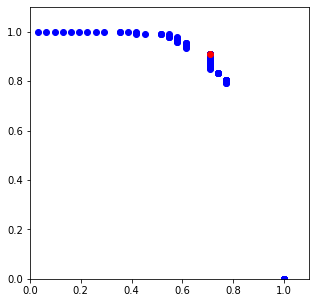

best_thre:0.325451597571373


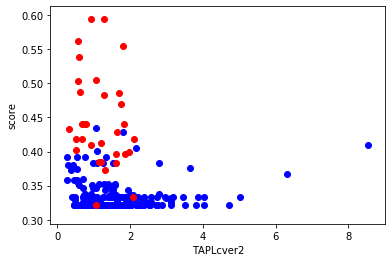

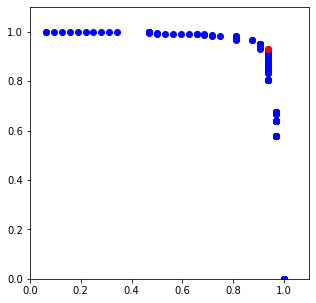

best_thre:0.33509408533573154
60%完了


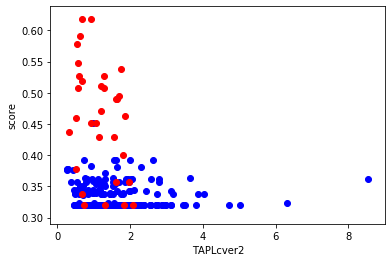

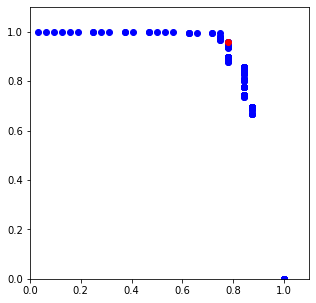

best_thre:0.3401068389415741


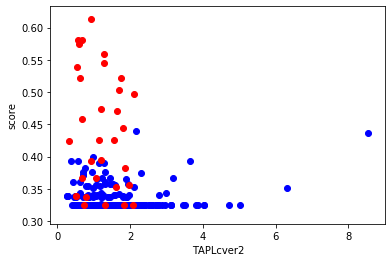

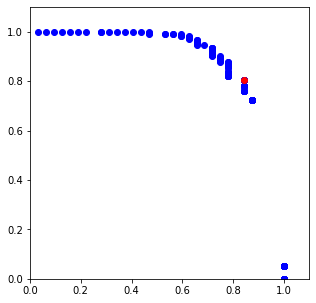

best_thre:0.3046095997095108
80%完了


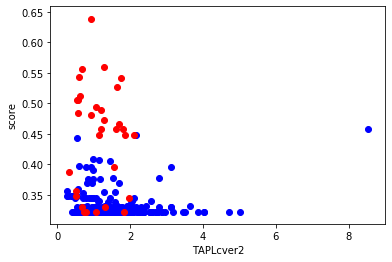

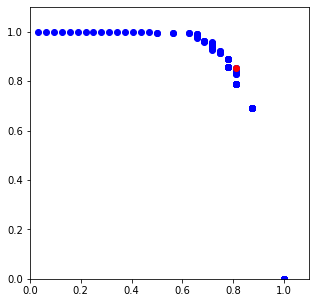

best_thre:0.31107533276081084


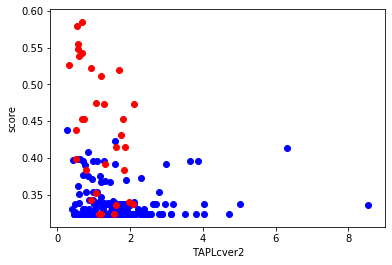

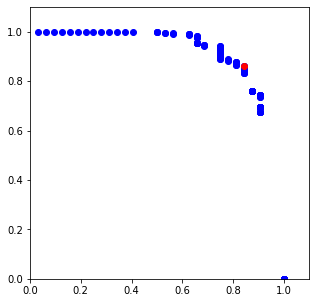

best_thre:0.30544137954711914
100%完了
実行時間:16s
0.1895424836601307
0.8285714285714286
0.20132013201320131


In [25]:
pre_xgb,imp_xgb,pre_test_xgb=machine_learning('xgb',cv_name,x_dummy,y,xgb_params)
print(mtr.f1_score(y,pre_test_xgb))
print(mtr.recall_score(y,pre_test_xgb))
print(mtr.recall_score(y,pre_test_xgb,pos_label=0))

In [26]:
print(35*.686)
print(303*.769)

24.01
233.007


In [27]:
importance=pd.DataFrame(imp_xgb,index=x_dummy.columns)
importance=importance[importance[0]>0]

<Figure size 432x288 with 0 Axes>

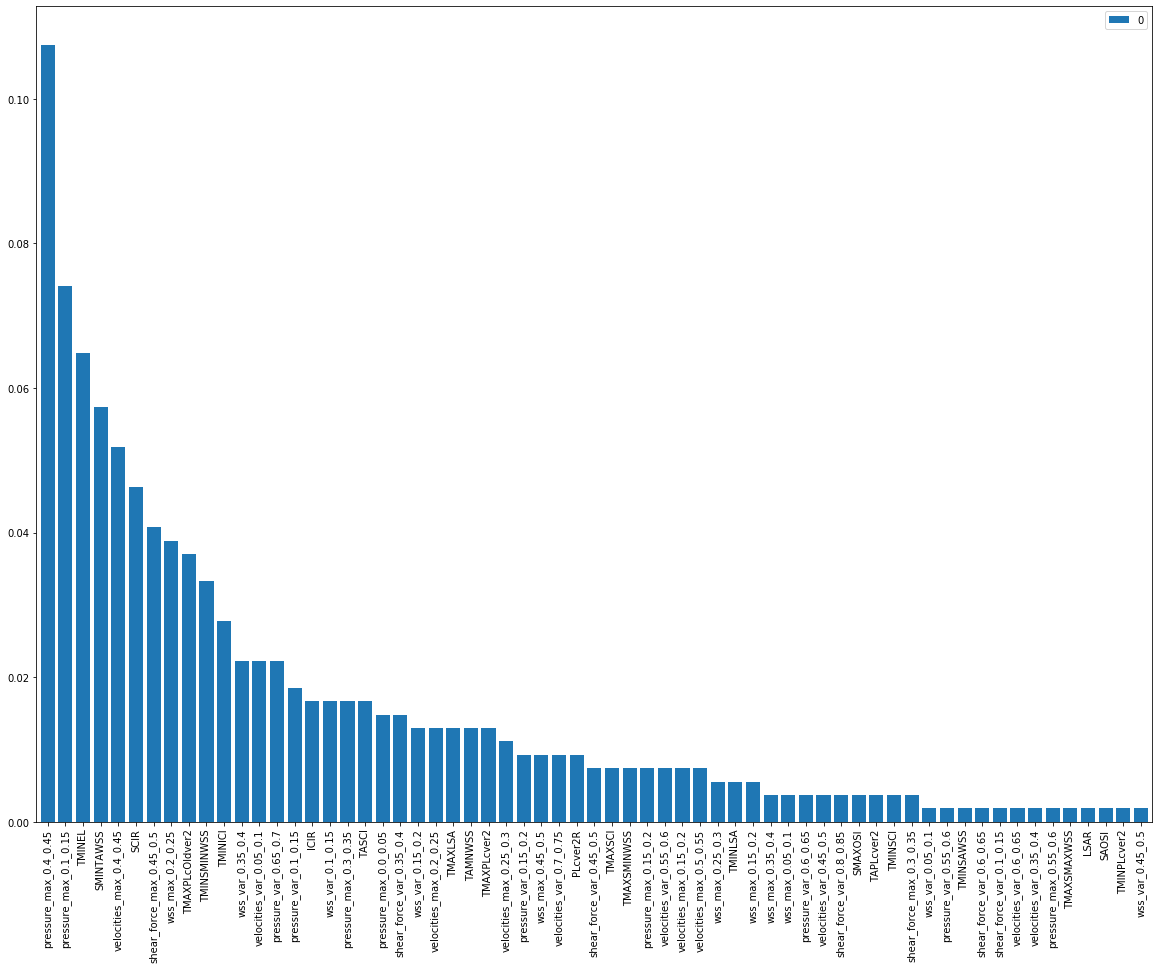

In [28]:
plt.figure()
df=importance.sort_values(0,ascending=False)
df.plot.bar(width=0.8,figsize=(20,15))
plt.savefig('../output/xgb_imp.png')

In [29]:
#x_new=make_data([pre,prob_svm,pre_xgb,pd.DataFrame(pre_test,index=x.index),pd.DataFrame(pre_test_svm,index=x.index),pd.DataFrame(pre_test_xgb,index=x.index)],['lgb','svm','xgb','lgb_c','svm_c','xgb_c'])
#pre_new,imp_new,pre_test_new=machine_learning('lgb',cv_name,x_new,y,lgb_params)
#tn, fp, fn, tp=mtr.confusion_matrix(y,pre_test_new).flatten()
#print(tp,fn,fp,tn)
#print(mtr.f1_score(y,pre_test_new))
#print(mtr.recall_score(y,pre_test_new))
#print(mtr.recall_score(y,pre_test_new,pos_label=0))

In [30]:
#pre_new2,imp_new2,pre_test_new2=machine_learning('xgb',cv_name,x_new,y,xgb_params)
#tn, fp, fn, tp=mtr.confusion_matrix(y,pre_test_new2).flatten()
#print(tp,fn,fp,tn)
#print(mtr.f1_score(y,pre_test_new2))
#print(mtr.recall_score(y,pre_test_new2))
#print(mtr.recall_score(y,pre_test_new2,pos_label=0))